In [1065]:
# importing packages and data set

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

microbe_dataSet = pd.read_csv('data/mimedb_microbes.csv')
disbiome_dataSet = pd.read_csv('data/disbiome_data.csv')

# Understanding Microbiome Data Set

## Data Schema:

| **Column Name**          | **Description**                                          |
|--------------------------|----------------------------------------------------------|
| **id**                   | Unique identifier for each record                        |
| **microbe_id**           | Identifier for the microbe                               |
| **name**                 | The name of the microbe                                  |
| **superkingdom**         | The broader superkingdom classification                  |
| **kingdom**              | The biological kingdom to which the microbe belongs      |
| **phylum**               | The phylum classification of the microbe                 |
| **klass**                | The class classification of the microbe                  |
| **order**                | The order classification of the microbe                  |
| **family**               | The family classification of the microbe                 |
| **genus**                | The genus classification of the microbe                  |
| **species**              | The species of the microbe                               |
| **strain**               | The strain or subtype of the microbe                     |
| **parent_id**            | Identifier for the parent record (if applicable)         |
| **level**                | Hierarchical level or classification                     |
| **ncbi_tax_id**          | The NCBI taxonomy identifier for the microbe             |
| **activity**             | Indicates if the microbe is active or inactive           |
| **gram**                 | Gram staining characteristic (positive or negative)      |
| **oxygen_requirement**   | The type of oxygen requirement for the microbe           |
| **metabolism**           | The metabolic characteristics of the microbe             |
| **shape**                | The shape of the microbe (e.g., cocci, bacilli)          |
| **mobility**             | Indicates if the microbe is mobile or immobile           |
| **flagella_presence**    | Indicates the presence or absence of flagella            |
| **number_of_membranes**  | Number of membranes the microbe has                      |
| **optimal_temperature**  | The optimal temperature for the microbe's growth         |
| **temperature_range**    | The temperature range within which the microbe can grow  |
| **habitat**              | The natural habitat of the microbe                       |
| **biotic_relationship**  | The type of biotic relationship the microbe has          |
| **cell_arrangement**     | The arrangement of cells in the microbe                  |
| **sporulation**          | Indicates if the microbe can form spores                 |
| **energy_source**        | The type of energy source used by the microbe            |
| **background**           | Additional background information about the microbe      |
| **health_type**          | Indicates the health implications (e.g., pathogenic)     |
| **evidence_type**        | The type of evidence supporting the microbe's classification |
| **data_source**          | The source of the data                                   |
| **export**               | Export status or related information                     |
| **human_pathogen**       | Indicates if the microbe is a human pathogen             |
| **genome_ids**           | Associated genome identifiers                            |
| **created_at**           | The date and time when the record was created            |
| **updated_at**           | The date and time when the record was last updated       |

(P.S Generated by ChatGPT)

# Data Cleaning

In [1066]:
def cleaning_oxy_req(ele):
    '''
    cleaned the input ele
    '''
    regex_pattern = r"/|;|,"

    if isinstance(ele, str):
        
        ele = re.split(regex_pattern, ele)[0]
        ele = ele.replace('\xa0', ' ')
        if ele == 'Nanaerobe':
            return 'Anaerobe'
        elif ele == 'Obligate anaerobe':
            return 'Anaerobe'
        elif ele == 'Facultatively anaerobe':
            return 'Facultative anaerobe'
        elif ele == 'Microaerophile':
            return 'Microaerophilic'
        else:
            return ele
    else:
        return ele

In [1067]:
cleaned_microbe_dataSet = microbe_dataSet.copy()

# reduing the dimension of the oxygen_requirements types
# there is correct type and take the dominate type
cleaned_microbe_dataSet['oxygen_requirement'] = microbe_dataSet['oxygen_requirement'].apply(cleaning_oxy_req)

# find the association between the microbe and the source
# the source will be the most frequent source
taxid_sources = disbiome_dataSet[['subject_taxid', 'association_sources']].dropna().groupby(['subject_taxid']).apply(lambda df: df.value_counts().idxmax()[1]).reset_index().rename(columns={0: 'association_sources'})

# convert 'created_at' 
cleaned_microbe_dataSet['created_at_m'] = cleaned_microbe_dataSet['created_at'].apply(lambda time : pd.Timestamp(time).to_period('M').month)
cleaned_microbe_dataSet['update_at_m'] = cleaned_microbe_dataSet['updated_at'].apply(lambda time : pd.Timestamp(time).to_period('M').month)

# merging the two data set
complete_microbe_sources = pd.merge(cleaned_microbe_dataSet, taxid_sources, left_on='ncbi_tax_id', right_on='subject_taxid', how='inner')
incomeplete_microbe_sources = pd.merge(cleaned_microbe_dataSet, taxid_sources, left_on='ncbi_tax_id', right_on='subject_taxid', how='left')
complete_microbe_sources['tax_id'] = complete_microbe_sources['ncbi_tax_id']
complete_microbe_sources = complete_microbe_sources.drop(columns=['ncbi_tax_id', 'subject_taxid'])
incomeplete_microbe_sources['tax_id'] = incomeplete_microbe_sources['ncbi_tax_id']
incomeplete_microbe_sources = incomeplete_microbe_sources.drop(columns=['ncbi_tax_id', 'subject_taxid'])

## Evaluating the Degree of Missingness of each column

### Visualizing Missing Value

In [1034]:
# predefined functions

def eval_missing(df):
    '''
    find the porportion of missingness of each column in the table.
    return the result as a series
    '''
    summary = df.isna().mean()

    summary.sort_values().plot(kind = 'barh', figsize=(10, 10))
    # Adding title and labels
    plt.title('Percentage of missing values in each column')
    plt.xlabel('Columns')
    plt.ylabel('Percentage of missing values')

    plt.axvline(x=0.4, color='r', linestyle='--', linewidth=2)
    plt.show()

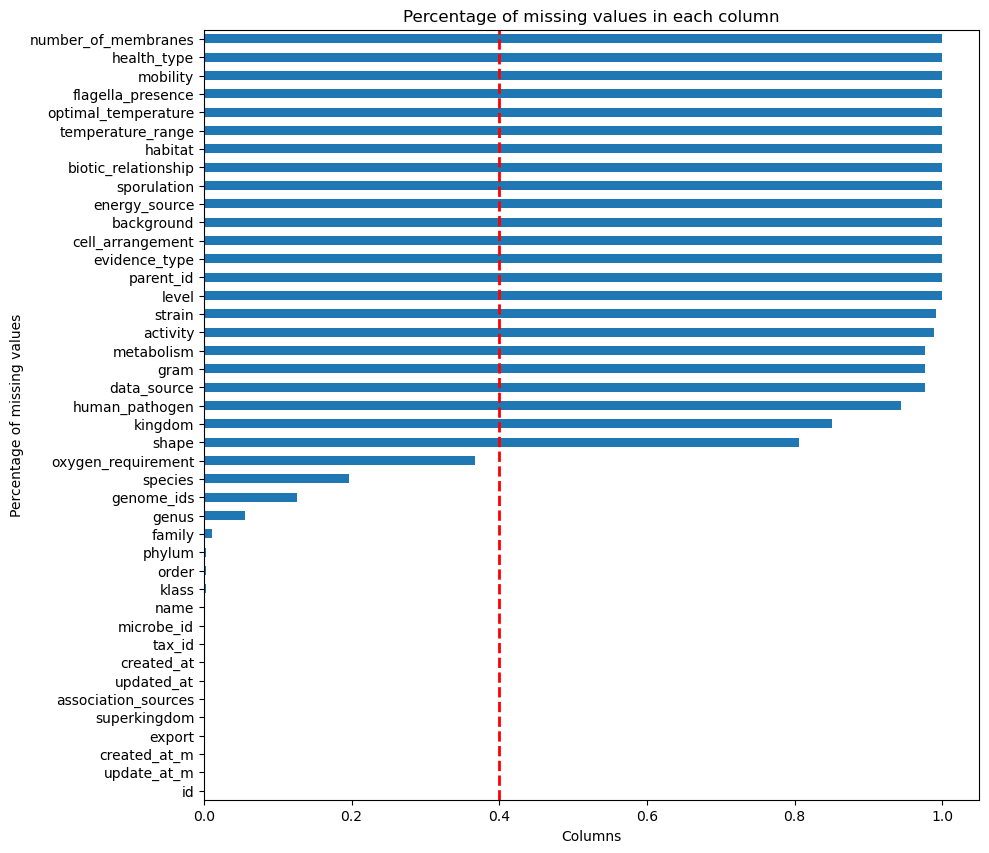

In [1035]:
eval_missing(complete_microbe_sources)

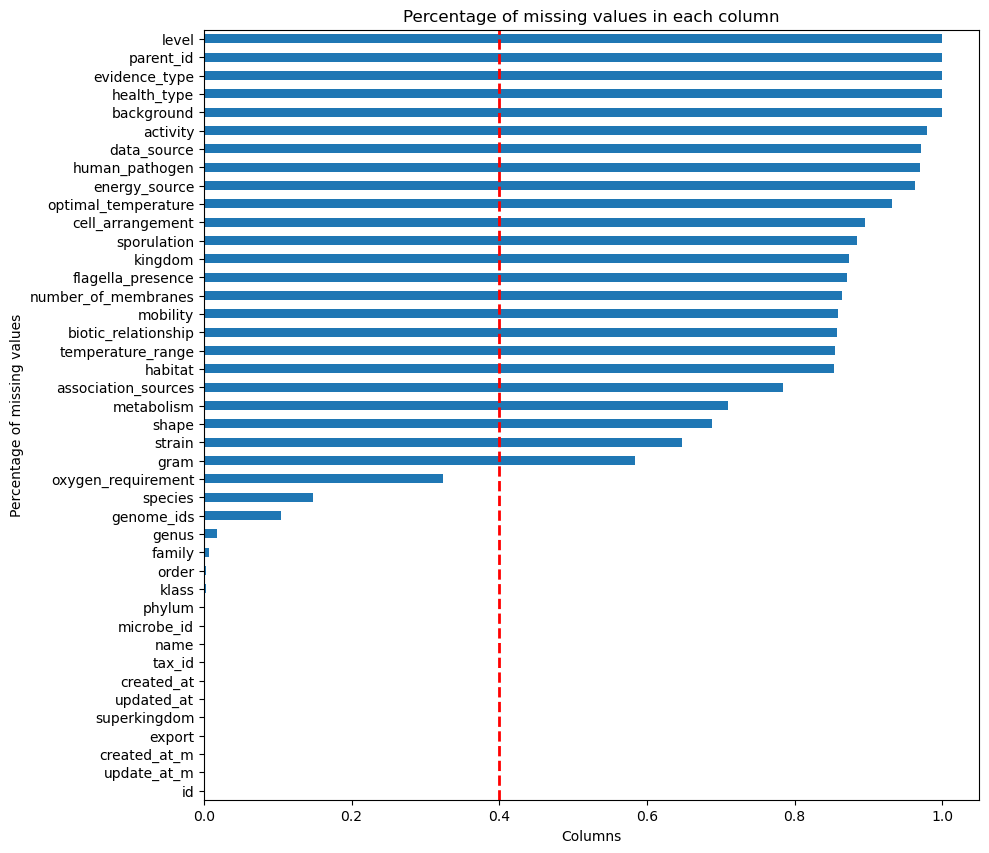

In [1036]:
eval_missing(incomeplete_microbe_sources)

### Filtering Out columns that has more than 40% missing value and other identifier

In [1037]:
filtered_complete_ms = complete_microbe_sources.drop(columns=complete_microbe_sources.columns[complete_microbe_sources.isna().mean() > 0.4])
filtered_incomplete_ms = incomeplete_microbe_sources.drop(columns=incomeplete_microbe_sources.columns[incomeplete_microbe_sources.isna().mean() > 0.4])

### Assessing the dependency of Missing rate in oxygen_requirements to other categorical columns

In [1038]:
# conducting TVD analysis of column with missingness against others
def tvd_testing(missing_col, testingCol):
    '''
    Conduct TVD analysis of the missingness of a column against another column.
    return the TVD value
    ---
    missing_col: pd.Series
        the column with missingness
    testingCol: pd.Series
        the column to test against
    ---
    return: float
        the TVD value
    '''
    missing_mask = missing_col.isnull()

    missing_testingCol_prop = testingCol[missing_mask].value_counts(normalize=True)
    unMissing_testingCol_prop = testingCol[~missing_mask].value_counts(normalize=True)

    # find all categories for the purpose of comparsion
    all_tvd_categories = missing_testingCol_prop.index.union(unMissing_testingCol_prop.index)
    missing_testingCol_prop = missing_testingCol_prop.reindex(all_tvd_categories, fill_value=0)
    unMissing_testingCol_prop = unMissing_testingCol_prop.reindex(all_tvd_categories, fill_value=0)

    return np.abs(missing_testingCol_prop - unMissing_testingCol_prop).sum() / 2

In [1039]:
tvd_testing_col = ['superkingdom', 'created_at_m', 'update_at_m', 'phylum', 'klass', 'order', 'family', 'genus', 'gram', 'export']

# check unqiue values for potential MAR columns
uniqueness = pd.DataFrame(columns=['column', 'unique_values'])
for col in tvd_testing_col:
    uniqueness = uniqueness.append({'column': col, 'unique_values': len(cleaned_microbe_dataSet[col].unique())}, ignore_index=True)
uniqueness.sort_values(by='unique_values')

,column,unique_values
9,export,1
0,superkingdom,4
2,update_at_m,4
1,created_at_m,7
8,gram,7
3,phylum,37
4,klass,80
5,order,159
6,family,299
7,genus,561


In [1040]:
tvd_testing_col = ['superkingdom', 'created_at_m', 'update_at_m', 'phylum', 'klass', 'gram']


# conduct TVD analysis
tvd_results = pd.DataFrame(columns = ['column', 'tvd'])
for colName in tvd_testing_col:
    tvd = tvd_testing(complete_microbe_sources['oxygen_requirement'], complete_microbe_sources[colName])
    tvd_results = tvd_results.append({'column': colName, 'tvd': tvd}, ignore_index=True)
tvd_results.sort_values(by='tvd', ascending=False)

,column,tvd
5,gram,0.500000
4,klass,0.499170
3,phylum,0.424708
0,superkingdom,0.412791
2,update_at_m,0.395349
1,created_at_m,0.336109


Interpretation:
- High tvd value indicating great difference on the distribution of categories of the missing and non-missing value
- genus, family, order, klass might be miss leading due to its scarsity
- these columns can be used to predict the oxygen_requirements

## Data Imputation

In [1041]:
CRITICAL_COL = ['superkingdom', 'created_at_m', 'update_at_m', 'phylum', 'klass', 'oxygen_requirement', 'association_sources']

In [1042]:
# repalce all the missing value with the most frequent value
simple_imputation_df = filtered_complete_ms.copy()
simple_imputation_df['oxygen_requirement'] = simple_imputation_df['oxygen_requirement'].fillna(simple_imputation_df['oxygen_requirement'].value_counts().index[0])

In [1043]:
# replace all the missing value based on the probabilistic model of the pre-exist data
prob_imputation_df = filtered_complete_ms.copy()
choices = np.array(prob_imputation_df['oxygen_requirement'].value_counts(normalize=True).index)
prob = np.array(prob_imputation_df['oxygen_requirement'].value_counts(normalize=True))
impute_value = np.random.choice(a = choices, size = prob_imputation_df['oxygen_requirement'].isna().sum(), p=prob)
prob_imputation_df.loc[prob_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = impute_value

In [1044]:
# replace all the missing value uses KNN model
knn_imputation_df = filtered_complete_ms.copy()

missing_data = knn_imputation_df[knn_imputation_df['oxygen_requirement'].isna()]
not_missing_data = knn_imputation_df[~knn_imputation_df['oxygen_requirement'].isna()]
 

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = KNeighborsClassifier()
model.fit(encoded_train, label)

# predict the missing value
predictions = model.predict(encoded_predict)
knn_imputation_df.loc[knn_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [1045]:
# replace all the missing value uses decision tree model
dt_imputation_df = filtered_complete_ms.copy()

missing_data = dt_imputation_df[dt_imputation_df['oxygen_requirement'].isna()]
not_missing_data = dt_imputation_df[~dt_imputation_df['oxygen_requirement'].isna()]
 

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = DecisionTreeClassifier()
model.fit(encoded_train, label)

# predict the missing value
predictions = model.predict(encoded_predict)
dt_imputation_df.loc[dt_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

In [1046]:
# replace all the missing value uses random forest model
rf_imputation_df = filtered_complete_ms.copy()

missing_data = rf_imputation_df[rf_imputation_df['oxygen_requirement'].isna()]
not_missing_data = rf_imputation_df[~rf_imputation_df['oxygen_requirement'].isna()]
 

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = RandomForestClassifier()
model.fit(encoded_train, label)

# predict the missing value
predictions = model.predict(encoded_predict)
rf_imputation_df.loc[rf_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

In [1047]:
# replace all the missing value uses logistic regression model
logistic_imputation_df = filtered_complete_ms.copy()

missing_data = logistic_imputation_df[logistic_imputation_df['oxygen_requirement'].isna()]
not_missing_data = logistic_imputation_df[~logistic_imputation_df['oxygen_requirement'].isna()]

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = LogisticRegression()
model.fit(encoded_train, label)

# predict the missing value
predictions = model.predict(encoded_predict)
logistic_imputation_df.loc[logistic_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1048]:
# replace all the missing value uses SVC model
svc_imputation_df = filtered_complete_ms.copy()

missing_data = svc_imputation_df[svc_imputation_df['oxygen_requirement'].isna()]
not_missing_data = svc_imputation_df[~svc_imputation_df['oxygen_requirement'].isna()]

# train knn model
train = not_missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict = missing_data[CRITICAL_COL].drop(columns=['oxygen_requirement', 'association_sources'])
predict['phylum'] = predict['phylum'].fillna(predict['phylum'].value_counts().index[0])
predict['klass'] = predict['klass'].fillna(predict['klass'].value_counts().index[0])
label = not_missing_data['oxygen_requirement']

encoder = OrdinalEncoder()
encoded_train = encoder.fit_transform(train)
encoded_predict = encoder.fit_transform(predict)

model = SVC()
model.fit(encoded_train, label)

predictions = model.predict(encoded_predict)
svc_imputation_df.loc[svc_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = predictions

## Imputation evaluation

In [1064]:
TEST_SIZE = 0.2

In [1050]:
def logistic_regression_classification(df):
    '''
    TODO
    '''

    train = df[CRITICAL_COL]
    train = df.dropna()

    X = pd.get_dummies(train.drop('association_sources', axis=1), drop_first=True)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(train['association_sources'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)


In [1051]:
class CustomCategoricalNB(CategoricalNB):
    def _joint_log_likelihood(self, X):
        jll = np.zeros((X.shape[0], len(self.classes_)))
        for i in range(self.n_features_in_):
            indices = X[:, i]
            # Handle unseen categories by assigning a small probability
            unseen_mask = indices >= self.feature_log_prob_[i].shape[1]
            indices[unseen_mask] = 0  # Assign unseen categories to index 0
            jll += self.feature_log_prob_[i][:, indices].T
            jll[unseen_mask, :] += np.log(0.1)  # Add log(0.1) for unseen categories
        total_ll = jll + self.class_log_prior_
        return total_ll

def naiveBased_classification(df):
    '''
    Perform Naive Bayes classification on the given DataFrame using CustomCategoricalNB.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing features and target.
    
    Returns:
    float: The accuracy score of the model.
    '''
    # Drop rows with missing values
    train = df.dropna()
    train = train[CRITICAL_COL]


    # Separate features and target
    X = train.drop(columns=['association_sources'])
    y = train['association_sources']

    # Encode categorical features
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X)


    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = CustomCategoricalNB()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)

In [1052]:
def decisionTree_classification(df):
    '''
    Perform Decision Tree classification on the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing features and target.
    
    Returns:
    float: The accuracy score of the model.
    '''
    # Drop rows with missing values
    train = df.dropna()
    train = train[CRITICAL_COL]

    # Separate features and target
    X = train.drop(columns=['association_sources'])
    y = train['association_sources']

    # Encode categorical features
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = DecisionTreeClassifier(random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)

In [1053]:
def randomForest_classification(df):
    '''
    Perform Random Forest classification on the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing features and target.
    
    Returns:
    float: The accuracy score of the model.
    '''
    # Drop rows with missing values
    train = df.dropna()
    train = train[CRITICAL_COL]

    # Separate features and target
    X = train.drop(columns=['association_sources'])
    y = train['association_sources']

    # Encode categorical features
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)

In [1054]:
def supportVectorMachine_classification(df):
    '''
    TODO
    '''
    # Drop rows with missing values
    train = df.dropna()
    train = train[CRITICAL_COL]

    # Separate features and target
    X = train.drop(columns=['association_sources'])
    y = train['association_sources']

    # Encode categorical features
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = SVC()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)


In [1055]:
def knn_classification(df):
    train = df.dropna()
    train = train[CRITICAL_COL]

    # Separate features and target
    X = train.drop(columns=['association_sources'])
    y = train['association_sources']

    # Encode categorical features
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    model = KNeighborsClassifier()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Return the accuracy score
    return accuracy_score(y_test, y_pred)

In [1056]:
def imputation_eval(imputed_df : dict, ml_models : dict):
    '''
    evaluting the performance of multiple models on the data set with different degree of imputation
    ---
    imputed_df: dictionary of pd.DataFrame 
        where the key is the imputation method and the value is the imputed data set
    ml_models: dictionary of functions with signature (X_train, y_train, X_test, y_test) -> float
        where the key is the model name and the value is the model function
    ---
    return: pd.DataFrame
        the result of the evaluation
    '''
    eval_result = pd.DataFrame(columns=['Algorithm', 'imputation_method', 'accuracy'])
    for modelName, model in ml_models.items(): 
        for impute_method, df in imputed_df.items():
            eval_result = eval_result.append({'imputation_method': impute_method, 'Algorithm': modelName, 'accuracy': model(df)},
                                              ignore_index=True)

    return eval_result

In [1057]:
imputation_results = imputation_eval({'non_imputation': filtered_complete_ms, 
                    'simple_imputation': simple_imputation_df,
                    'simple_prob_imputation': prob_imputation_df,
                    'knn_imputation': knn_imputation_df,
                    'dt_imputation': dt_imputation_df,
                    'rf_imputation': rf_imputation_df,
                    'logistic_imputation': logistic_imputation_df,
                    'svc_imputation': svc_imputation_df}, 
                {'logistic classification': logistic_regression_classification,
                'naiveBased_classification': naiveBased_classification,
                'decisionTree_classification': decisionTree_classification,
                'randomForest_classification': randomForest_classification,
                'supportVectorMachine_classification': supportVectorMachine_classification,
                'knn_classification': knn_classification})

/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [1058]:
imputation_results

,Algorithm,imputation_method,accuracy
0,logistic classification,non_imputation,0.545455
1,logistic classification,simple_imputation,0.555556
2,logistic classification,simple_prob_imputation,0.555556
3,logistic classification,knn_imputation,0.555556
4,logistic classification,dt_imputation,0.555556
5,logistic classification,rf_imputation,0.555556
6,logistic classification,logistic_imputation,0.555556
7,logistic classification,svc_imputation,0.555556
8,naiveBased_classification,non_imputation,0.509434
9,naiveBased_classification,simple_imputation,0.500000


# Interpretation

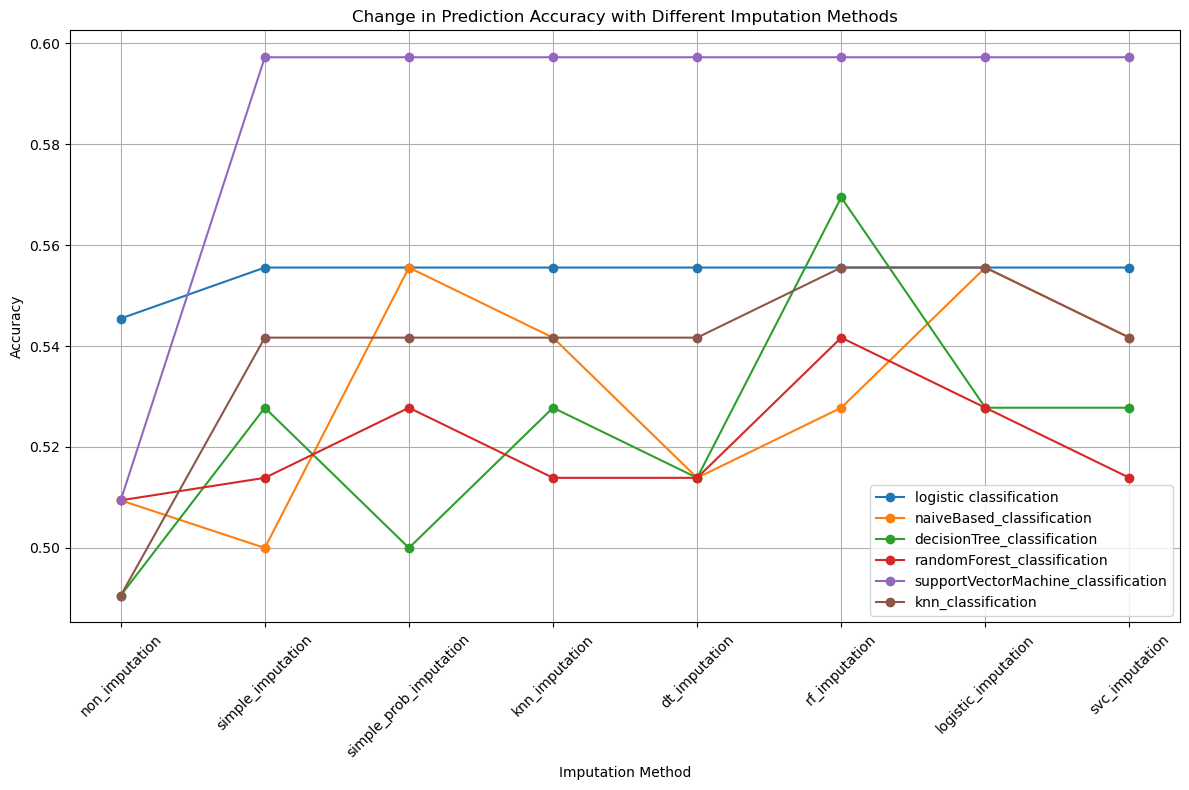

In [1059]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_results(imputation_results):
    '''
    Plot the change in prediction accuracy of different classification algorithms with different imputation methods.
    
    Parameters:
    imputation_results (pd.DataFrame): The DataFrame containing the accuracy results.
    '''
    plt.figure(figsize=(12, 8))
    for algorithm in imputation_results['Algorithm'].unique():
        subset = imputation_results[imputation_results['Algorithm'] == algorithm]
        plt.plot(subset['imputation_method'], subset['accuracy'], marker='o', label=algorithm)

    plt.title('Change in Prediction Accuracy with Different Imputation Methods')
    plt.xlabel('Imputation Method')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming imputation_results is already defined and populated
plot_results(imputation_results)

In [1060]:
original = imputation_results[imputation_results['imputation_method'] == 'non_imputation']
original

,Algorithm,imputation_method,accuracy
0,logistic classification,non_imputation,0.545455
8,naiveBased_classification,non_imputation,0.509434
16,decisionTree_classification,non_imputation,0.490566
24,randomForest_classification,non_imputation,0.509434
32,supportVectorMachine_classification,non_imputation,0.509434
40,knn_classification,non_imputation,0.490566


In [1061]:
def test1(df):
    compare = original.merge(df, on='Algorithm', suffixes=('_original', '_imputed'))
    diff = ((compare['accuracy_imputed'] - compare['accuracy_original']) / compare['accuracy_original']).mean()
    return diff

In [1062]:
imputation_results[imputation_results['imputation_method'] != 'non_imputation'].groupby('imputation_method').apply(test1).sort_values()

imputation_method
dt_imputation             0.060007
simple_imputation         0.060182
simple_prob_imputation    0.073464
knn_imputation            0.073814
svc_imputation            0.073814
logistic_imputation       0.087620
rf_imputation             0.097232
dtype: float64

In [1063]:
imputation_results[imputation_results['Algorithm'] == 'supportVectorMachine_classification']

,Algorithm,imputation_method,accuracy
32,supportVectorMachine_classification,non_imputation,0.509434
33,supportVectorMachine_classification,simple_imputation,0.597222
34,supportVectorMachine_classification,simple_prob_imputation,0.597222
35,supportVectorMachine_classification,knn_imputation,0.597222
36,supportVectorMachine_classification,dt_imputation,0.597222
37,supportVectorMachine_classification,rf_imputation,0.597222
38,supportVectorMachine_classification,logistic_imputation,0.597222
39,supportVectorMachine_classification,svc_imputation,0.597222
